# Amazon Copurchased

This is a Python notebook created using "jupyter".

Author: Rafael J. P. dos Santos

## Condições do experimento

-

## Parameters

We use the parameter below to set the maximum number of edges to be read from the CSV containing edges (links).

In [1]:
max_edges = 5000 # Set quantity to read from file
edges_csv_file = "data/20180812_links"
nodes_csv_file = "data/20180812_nodes"

## Load the libraries

Let's load the Python libraries that we will need throughout the script

In [2]:
%load_ext autoreload
%autoreload 1
%aimport shared_functions
import pandas as pd
import numpy as np
from __future__ import division
import shared_functions
from IPython.display import display, HTML

## Read graph

### Read only first lines of datafile

Due to slowness in calculating centrality measures, we use the parameter provided in the beggining of the script to limit the number of edges we will read.

In [3]:
G = shared_functions.read_G(edges_csv_file, max_edges)

Using 5000 edges out of 229338 available (2.18% of data)


### Calculate nodes centrality measures

Now that we have our NetworkX graph, let's calculate some centrality measures for every node.

In [4]:
centrality_measures = shared_functions.centrality_measures(G)
print centrality_measures.keys()

['eigenvector_centrality', 'degree', 'betweenness_centrality']


### Load node properties

Let's load the CSV containing the nodes data (title, price) into a Pandas dataframe, and append the centrality measures calculated above.

In [5]:
df = pd.read_csv(nodes_csv_file)

####  Convert ID to random int to avoid leaking knowledge

In [6]:
df = shared_functions.add_sha256_column_from_id(df)

#### Add centrality measures

In [7]:
df = shared_functions.merge_columns(df, centrality_measures)

### Let's convert some fields to numeric

In [8]:
categorical_features = [
    'category1',
    'category2',
    'category3',
    'category4',
    'category5',
    'category6',
    'category7',
    'category8',
    'category9',
    'category10',
    'language',
    'coverType',
    'publisher',
    'rankingCategory',
    'authors'
]

numeric_features = [
    #'degree',
    #'eigenvector_centrality',
    #'betweenness_centrality',
    'ranking',
    'reviewCount',
    'pages',
    'weight',
    'height',
    'width',
    'depth',
    'rating'
]

df = shared_functions.prepare_data(df, numeric_features)

### Remove nodes without price

In [9]:
df = df.drop(df[df["price"].isnull()].index)

### Inspect columns

In [10]:
df.columns

Index([u'id', u'title', u'url', u'authors', u'coverType', u'publisher',
       u'edition', u'publicationDate', u'rankingCategory', u'category1',
       u'category2', u'category3', u'category4', u'category5', u'category6',
       u'category7', u'category8', u'category9', u'category10', u'isbn10',
       u'isbn13', u'language', u'postProcessed', u'price', u'ranking',
       u'pages', u'reviewCount', u'rating', u'width', u'height', u'depth',
       u'weight', u'sha256_id', u'eigenvector_centrality', u'degree',
       u'betweenness_centrality'],
      dtype='object')

### Features summary

Below we have a summary of the Pandas dataframe. We can see the number of nodes that we are actually analyzing, which depends on the max_edges parameter defined before.

In [11]:
pd.set_option('display.max_columns', None)
df.describe(include='all', percentiles=[0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99])

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,sha256_id,eigenvector_centrality,degree,betweenness_centrality
count,1115.000000,1115,1115,1115,1104,1104,0.0,194,957,953,953,824,533,335,92,6,0.0,0.0,0.0,1106,1106,1106,1115.0,1115.000000,1115.000000,1115.000000,1115.000000,1115.00000,1115.000000,1115.000000,1115.000000,1115.000000,1.115000e+03,1.115000e+03,1115.000000,1115.000000
unique,NaN,1082,1115,908,4,202,NaN,181,1,1,20,85,116,83,27,3,NaN,NaN,NaN,1106,1106,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Macroeconomia,https://www.amazon.com.br/dp/8563308327/,Ian Stewart (Autor),Capa comum,Dover Publications,NaN,25 de agosto de 2017,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Faculdade,Probabilidade e Estatística,Abstrata,NaN,NaN,NaN,8537811912,978-8582600481,Português,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5,1,9,879,65,NaN,3,957,953,307,243,123,39,12,3,NaN,NaN,NaN,1,1,650,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,1210.100448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,160.345901,68257.219982,421.502570,16.047492,4.50152,16.420105,23.380242,2.360367,493.613204,2.088706e+09,1.269202e-02,7.729148,0.005750
std,1391.410003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,251.568529,82770.534322,241.927539,39.849545,0.45078,2.739705,2.618346,1.131093,204.941036,1.197815e+09,2.650271e-02,16.233822,0.015771
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.900000,7.000000,4.000000,1.000000,1.00000,10.000000,16.800000,0.400000,22.700000,9.916600e+05,9.095504e-07,1.000000,0.000000
25%,300.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,39.700000,13826.500000,256.000000,3.000000,4.50624,14.600000,21.600000,1.600000,358.000000,1.085672e+09,1.556060e-04,1.000000,0.000000
50%,728.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,67.570000,43904.000000,368.000000,16.212800,4.50624,15.900000,23.000000,2.200000,496.081798,2.080364e+09,6.422648e-04,2.000000,0.001080
75%,1861.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,157.840000,69459.166331,539.500000,16.212800,4.70000,17.900000,24.600000,3.000000,599.000000,3.082842e+09,1.473573e-02,8.000000,0.003680


Below we can inspect the first rows of data, containing title, price, degree and other centrality measures.

In [12]:
df.head(10)

,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,sha256_id,eigenvector_centrality,degree,betweenness_centrality
0,1,The Stanford Mathematics Problem Book: With Hi...,https://www.amazon.com.br/dp/0486469247/,"George Polya (Autor),",Capa comum,Dover Publications,NaN,19 de fevereiro de 2009,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Estudo e Ensino,NaN,NaN,NaN,NaN,NaN,0486469247,978-0486469249,Inglês,1,26.25,59183.0,68.0,1.0000,4.00000,14.0,21.0,0.6,181.0,3564330554,0.028760,19,0.009044
1,2,Fourier Series,https://www.amazon.com.br/dp/0486633179/,"Georgi P. Tolstov (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1976,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Probabilidade e Estatística,NaN,NaN,NaN,NaN,0486633179,978-0486633176,Inglês,1,50.37,56112.0,352.0,3.0000,4.60000,14.6,21.0,1.9,363.0,1309098117,0.111116,62,0.008309
2,3,Probability Theory: A Concise Course,https://www.amazon.com.br/dp/0486635449/,"Y. A. Rozanov (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Probabilidade e Estatística,NaN,NaN,NaN,NaN,0486635449,978-0486635446,Inglês,1,29.23,44345.0,160.0,16.2128,4.50624,14.4,20.8,0.8,200.0,1260550007,0.096490,59,0.018390
3,4,"Vectors, Tensors and the Basic Equations of Fl...",https://www.amazon.com.br/dp/0486661105/,"Rutherford Aris (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Engenharia e Transporte,Engenharia,Mecânica,Hidráulica,NaN,NaN,NaN,NaN,0486661105,978-0486661100,Inglês,1,48.79,82275.0,320.0,2.0000,4.50000,13.7,21.5,1.6,381.0,4012708477,0.031141,18,0.008677
4,5,Ordinary Differential Equations,https://www.amazon.com.br/dp/0486649407/,"Morris Tenenbaum (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Equações Diferenciais,NaN,NaN,NaN,NaN,0486649407,978-0486649405,Inglês,1,71.63,40840.0,848.0,4.0000,4.50000,13.8,21.8,4.0,939.0,3891707921,0.138285,88,0.028186
5,6,The Variational Principles of Mechanics,https://www.amazon.com.br/dp/0486650677/,"Cornelius Lanczos (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486650677,978-0486650678,Inglês,1,88.15,36960.0,418.0,1.0000,5.00000,13.8,21.5,2.2,581.0,2030201243,0.090919,43,0.020745
6,7,A First Look at Perturbation Theory,https://www.amazon.com.br/dp/0486675513/,James G. Simmonds (Autor),Capa comum,Dover Publications Inc.,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Equações Diferenciais,NaN,NaN,NaN,NaN,0486675513,978-0486675510,Inglês,1,36.10,37291.0,160.0,16.2128,4.50624,13.7,21.5,0.8,159.0,744636978,0.014744,9,0.001313
7,8,Thermodynamics and the Kinetic Theory of Gases...,https://www.amazon.com.br/dp/0486414612/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,18 de outubro de 2010,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Dinâmica,Termodinâmica,NaN,NaN,NaN,NaN,0486414612,978-0486414614,Inglês,1,26.01,24406.0,160.0,2.0000,5.00000,13.8,21.6,1.0,159.0,425205287,0.011709,10,0.015377
8,9,Mechanics,https://www.amazon.com.br/dp/0486607542/,"Jacob P. Den Hartog (Autor),",Capa comum,Dover Publications,NaN,1 de junho de 1961,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486607542,978-0486607542,Inglês,1,50.96,90609.0,480.0,16.2128,4.50624,13.6,20.3,2.3,522.0,1246026773,0.041870,23,0.008558
9,10,Statistical Thermodynamics,https://www.amazon.com.br/dp/0486661016/,"Erwin Schrodinger (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras 

## Random forest using various features, price as target

### Preparing data

In [13]:
target, features, feature_list, test_features, test_target = shared_functions.prepare_datasets(df, numeric_features, categorical_features, 'price')

Numeric features:  ['ranking', 'reviewCount', 'pages', 'weight', 'height', 'width', 'depth', 'rating']
Categorical features:  ['category1', 'category2', 'category3', 'category4', 'category5', 'category6', 'category7', 'category8', 'category9', 'category10', 'language', 'coverType', 'publisher', 'rankingCategory', 'authors']
Target column:  price
Test percentage:  0.2
Train features shape:  (892, 1450)
Train target shape:  (892,)
Test features shape:  (223, 1450)
Test target shape:  (223,)


### Average price and median price as baselines

It's important to have a baseline, so we can validate our predictions after running our model. One easy choice for baseline is the average price of a book.

We have an average price around R\$43, so this means that a very easy prediction would be to always guess R$43 for the price of any book.

In [14]:
average_target = np.average(target)
median_target = np.median(target)
print "Average price: R$", average_target
print "Median parice; R$", median_target

Average price: R$ 163.8232062780269
Median parice; R$ 67.525


### Cross val

#### Run cross val

In [15]:
estimators, splits, scores = shared_functions.run_cross_validation_regression(features, target)

#### Cross val score

In [16]:
shared_functions.print_score_summary(scores)

=== Relative
RF relative abs mean:  0.41472880476479473
RF relative abs std:  0.07576046953027445
Baseline (average) relative mean:  2.1655442038275505
Baseline (average) relative std:  0.22075175049567178
Baseline (median) relative mean:  0.7571980288668939
Baseline (median) relative std:  0.08425928238061238
=== Absolute
RF abs mean:  67.26913783770286
RF abs std:  14.232929874082004
Baseline (average) mean:  153.09191023552398
Baseline (average) std:  14.474674634134109
Baseline (median) mean:  123.43836142322098
Baseline (median) std:  17.695153569806607


####  List of most important features

In [17]:
shared_functions.get_most_important_features(estimators, feature_list)

,feature,mean importance,std,std/mean
0,coverType_Capa dura,24.229457,1.339876,0.055299
1,ranking,9.544416,1.025612,0.107457
2,publisher_McGraw-Hill Science/Engineering/Math,9.506689,3.355733,0.352986
3,publisher_Cengage Learning,8.003113,1.819531,0.227353
4,pages,6.804563,0.830996,0.122123
5,height,3.652585,0.317380,0.086892
6,width,2.991524,0.388019,0.129706
7,authors_S. M. Neill C. M. Ridley (Autor),2.367122,0.844039,0.356568
8,"authors_Lars V. Ahlfors (Autor),",2.258839,1.431660,0.633804
9,depth,2.064714,0.254415,0.123220


### Predicted price vs real price

Splits quantity:  10
Splits lenghts:  [90, 90, 89, 89, 89, 89, 89, 89, 89, 89]
X shape:  (892, 1450)
y shape:  (892,)


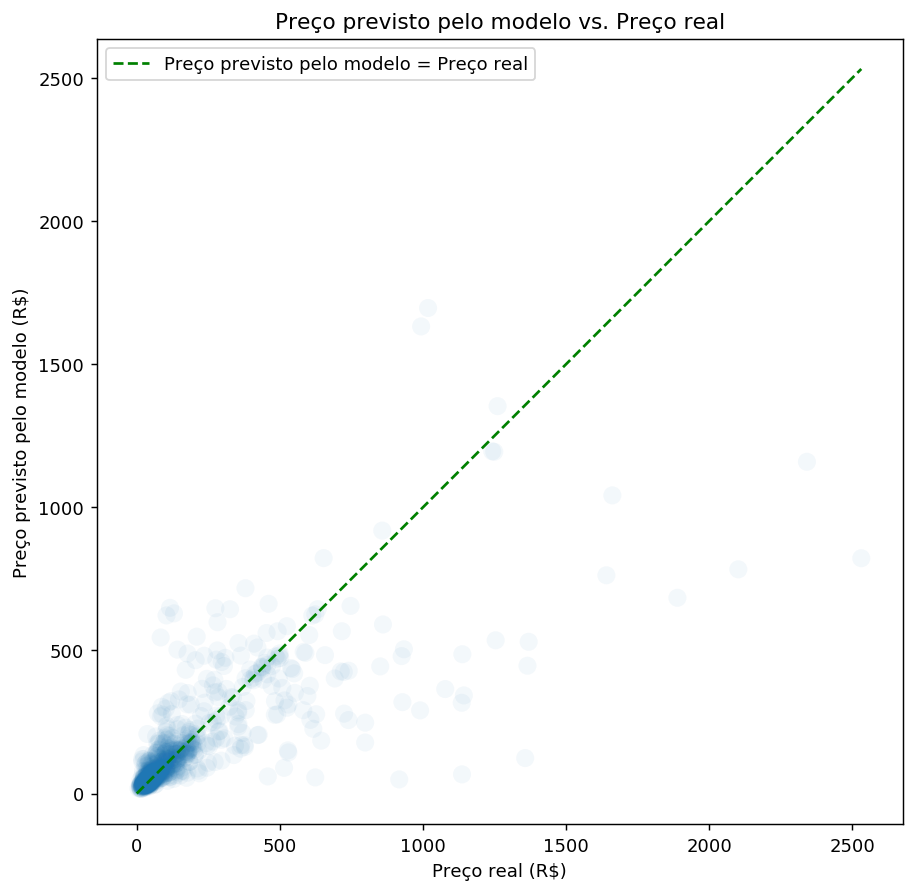

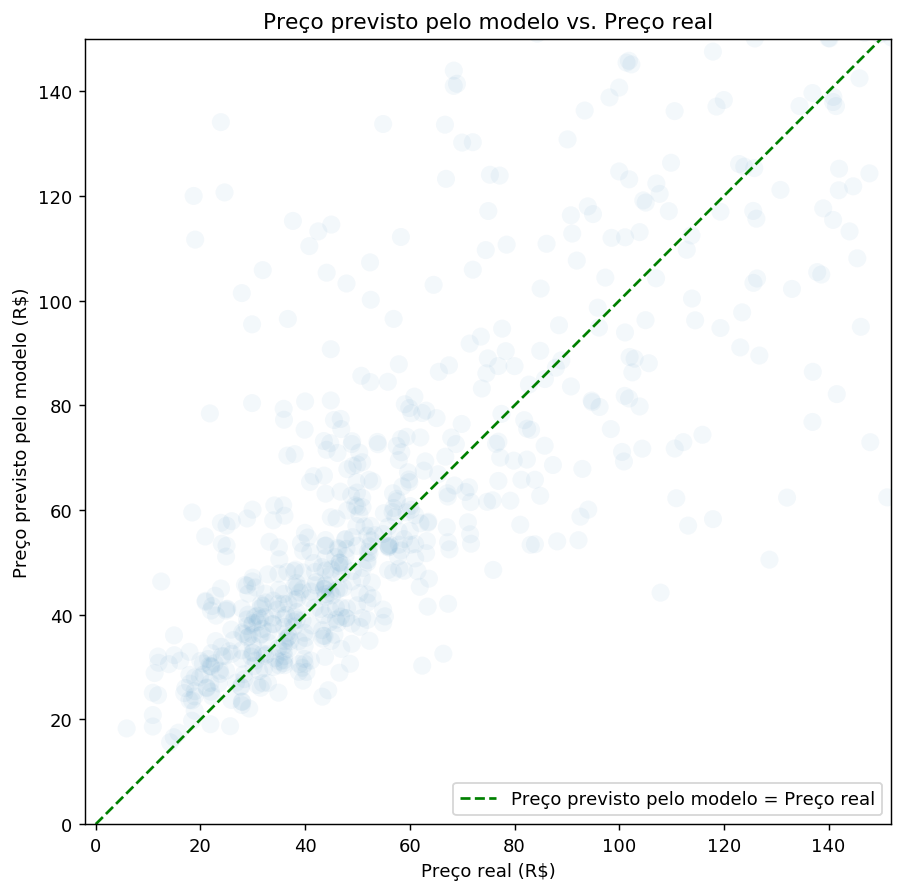

In [18]:
y_pred = shared_functions.get_all_predictions_from_splits(features, target, splits, estimators)                                                  
shared_functions.plot_splits_predicted_vs_real(target, y_pred, title=u'Preço previsto pelo modelo vs. Preço real', xlabel=u'Preço real (R$)', ylabel=u'Preço previsto pelo modelo (R$)', legend=u'Preço previsto pelo modelo = Preço real', zoomY = 150)

### Mean absolute error

Now we can compare the errors obtained by our predictions against the errors provided by the baseline (average price). Our prediction errors should be less than the baseline errors to consider the model successful.

In [19]:
errors, errors_baseline, errors_relative, errors_baseline_relative, errors_baseline_median, errors_baseline_median_relative = shared_functions.print_mean_absolute_error(y_pred, target, average_target, median_target)

== Absolute
('Mean absolute prediction error: R$', 67.28)
('Std prediction error: R$', 159.21)
('Mean absolute error using average: R$', 153.12)
('Std prediction error using average: R$', 212.52)
('Mean absolute error using median: R$', 123.49)
('Std prediction error using median: R$', 250.27)
== Relative
('Mean relative absolute prediction error: ', 0.41)
('Std relative prediction error: ', 0.61)
('Mean relative absolute error using average: ', 2.17)
('Std relative prediction error using average: ', 2.37)
('Mean absolute error using median: R$', 0.76)
('Std prediction error using median: R$', 0.77)


### Join data

In [20]:
pd.set_option('display.max_columns', None)
predicted_df, joined_predicted_df = shared_functions.join_predicted_df(df, features, target, y_pred, errors, errors_relative, errors_baseline, errors_baseline_relative, errors_baseline_median, errors_baseline_median_relative)

### Worst absolute predictions

Below we can inspect the rows with the biggest prediction error.

In [21]:
joined_predicted_df.sort_values('error', ascending = False).head(20)

,all_features,error,error_baseline,error_baseline_median,error_baseline_median_relative,error_baseline_relative,error_relative,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4.565469e+08,"[456546893.0, 69459.1663306, 16.2128, 345.0, 4...",1709.14088,2367.246794,2463.545,0.973322,0.935275,0.675264,821.92912,2531.07,1685,Complex Analysis Complex Analysis Complex Anal...,https://www.amazon.com.br/dp/0070006571/,"Lars V. Ahlfors (Autor),",Capa dura,McGraw-Hill Science/Engineering/Math,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0070006571,978-0070006577,Inglês,1,2531.07,69459.166331,345.000000,16.2128,4.50624,16.000000,23.100000,2.500000,496.081798,0.027156,6,0.000873
1.144179e+09,"[1144179495.0, 69459.1663306, 16.2128, 432.0, ...",1318.41252,1937.716794,2034.015,0.967869,0.922046,0.627355,783.12748,2101.54,1991,Machine Learning,https://www.amazon.com.br/dp/0070428077/,"Tom M. Mitchell (Autor),",Capa dura,McGraw-Hill Science/Engineering/Math,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0070428077,978-0070428072,Inglês,1,2101.54,69459.166331,432.000000,16.2128,4.50624,16.800000,24.100000,3.300000,921.000000,0.002774,1,0.000000
1.993779e+09,"[1993779221.0, 69459.1663306, 16.2128, 425.124...",1233.18918,1193.176794,1289.475,0.950239,0.879275,0.908761,123.81082,1357.00,1716,A VULVA 2 Ed 2003,https://www.amazon.com.br/dp/8126532289/,S. M. Neill C. M. Ridley (Autor),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8126532289,978-8126532285,Inglês,1,1357.00,69459.166331,425.124144,16.2128,4.50624,16.479794,23.433534,2.372055,496.081798,0.069915,18,0.003887
9.158984e+07,"[91589843.0, 311760.0, 16.2128, 545.0, 496.081...",1205.03838,1724.936794,1821.235,0.964249,0.913264,0.638005,683.72162,1888.76,1712,Vector Calculus,https://www.amazon.com.br/dp/1429215089/,"Jerrold E. Marsden (Autor),",Capa dura,W.H. Freeman & Company,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Aplicada,Análise Vetorial,NaN,NaN,NaN,NaN,1429215089,978-1429215084,Inglês,1,1888.76,311760.000000,545.000000,16.2128,4.50624,21.000000,26.000000,3.200000,496.081798,0.016731,4,0.000986
1.731114e+09,"[1731113829.0, 69459.1663306, 16.2128, 688.0, ...",1182.37242,2177.376794,2273.675,0.971158,0.930026,0.505028,1158.82758,2341.20,1779,Modern Physics for Scientists and Engineers,https://www.amazon.com.br/dp/1133103723/,"Stephen T. Thornton (Autor),",Capa dura,Cengage Learning,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1133103723,978-1133103721,Inglês,1,2341.20,69459.166331,688.000000,16.2128,4.50624,20.300000,25.400000,3.200000,496.081798,0.011562,2,0.000456
1.088718e+09,"[1088718135.0, 69459.1663306, 16.2128, 224.0, ...",1069.42574,972.456794,1068.755,0.940574,0.855825,0.941164,66.85426,1136.28,1830,Geometric Algebra,https://www.amazon.com.br/dp/0471608394/,E. Artin (Autor),Capa comum,Wiley-Blackwell,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0471608394,978-0471608394,Inglês,1,1136.28,69459.166331,224.000000,16.2128,4.50624,14.700000,22.900000,1.200000,308.000000,0.085287,27,0.006704
2.866815e+09,"[2866815273.0, 214548.0, 16.2128, 839.0, 496.0...",918.54366,1201.116794,1297.415,0.950529,0.879978,0.672955,446.39634,1364.94,317,Mathematical Methods in the Physical Sciences,https://www.amazon.com.br/dp/0471198269/,Mary L. Boas (Autor),Capa dura,John Wiley & Sons,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Física Matemática,NaN,NaN,NaN,NaN,NaN,0471198269,978-0471198260,Inglês,1,1364.94,214548.000000,839.000000,16.2128,4.50624,18.300000,25.500000,3.400000,496.081798,0.030778,6,0.001953
2.413888e+09,"[2413888158.0, 380246.0, 1

### Worst relative predictions

In [22]:
joined_predicted_df.sort_values('error_relative', ascending = False).head(20)

,all_features,error,error_baseline,error_baseline_median,error_baseline_median_relative,error_baseline_relative,error_relative,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1.487078e+08,"[148707819.0, 198305.0, 1.0, 416.0, 739.0, 24....",461.61096,80.383206,15.915,0.190736,0.963365,5.532250,545.05096,83.44,2252,Maker of Patterns – An Autobiography Through L...,https://www.amazon.com.br/dp/0871403862/,Freeman Dyson (Autor),Capa dura,Liveright,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0871403862,978-0871403865,Inglês,1,83.44,198305.000000,416.000000,1.0000,5.00000,16.800000,24.400000,3.600000,739.000000,0.028342,4,0.000918
9.535769e+08,"[953576854.0, 69459.1663306, 16.2128, 425.1241...",101.30662,145.123206,48.825,2.610963,7.760599,5.417466,120.00662,18.70,129,50 Ideias de Física Quântica,https://www.amazon.com.br/dp/8542206045/,Joanne Baker (Autor),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,18.70,69459.166331,425.124144,16.2128,4.50624,16.479794,23.433534,2.372055,496.081798,0.005967,69,0.038480
2.360942e+08,"[236094234.0, 77874.0, 16.2128, 514.0, 496.081...",518.00342,59.823206,36.475,0.350721,0.575223,4.980802,622.00342,104.00,442,Física Nuclear e de Partículas. Uma Introdução,https://www.amazon.com.br/dp/8578614070/,"Salomon S. Mizrahi (Autor),",Capa dura,Livraria da Física,NaN,NaN,Livros,Livros,Ciências,Física,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8578614070,978-8578614072,Português,1,104.00,77874.000000,514.000000,16.2128,4.50624,18.000000,24.600000,3.200000,496.081798,0.000494,3,0.012084
1.123179e+09,"[1123179230.0, 2813.0, 2.0, 528.0, 780.0, 23.8...",92.67778,144.833206,48.535,2.555819,7.626814,4.880346,111.66778,18.99,424,O Livro de Ouro do Universo,https://www.amazon.com.br/dp/8569809832/,Ronaldo Rogério de Freitas Mourão (Autor),Capa comum,HarperCollins Brasil,NaN,NaN,Livros,Livros,Ciências,Astronomia e Ciência Espacial,Astronomia,NaN,NaN,NaN,NaN,NaN,NaN,8569809832,978-8569809838,Português,1,18.99,2813.000000,528.000000,2.0000,4.00000,17.000000,23.800000,2.600000,780.000000,0.000712,5,0.003552
2.674498e+09,"[2674497925.0, 426261.0, 1.0, 149.0, 118.0, 16...",170.87794,126.813206,30.515,0.824507,3.426458,4.617075,207.88794,37.01,1484,Happiness,https://www.amazon.com.br/dp/0199590605/,Daniel M. Haybron (Autor),Capa comum,"Oxford University Press, USA",NaN,1 de outubro de 2013,Livros,Livros,Inglês e Outras Línguas,"Política, Filosofia e Ciências Sociais",Filosofia,NaN,NaN,NaN,NaN,NaN,NaN,0199590605,978-0199590605,Inglês,1,37.01,426261.000000,149.000000,1.0000,5.00000,11.200000,16.800000,1.000000,118.000000,0.000595,1,0.000000
4.006253e+09,"[4006253053.0, 69459.1663306, 16.2128, 425.124...",110.20934,139.923206,43.625,1.825314,5.854527,4.611269,134.10934,23.90,130,50 Ideias de Matemática que Você Precisa Conhecer,https://www.amazon.com.br/dp/8542208862/,Tony Crilly (Autor),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,23.90,69459.166331,425.124144,16.2128,4.50624,16.479794,23.433534,2.372055,496.081798,0.004915,62,0.081089
1.879984e+09,"[1879983517.0, 428052.0, 16.2128, 400.0, 590.0...",532.45522,47.693206,48.605,0.418540,0.410688,4.584993,648.58522,116.13,1853,Burn Math Class: And Reinvent Mathematics for ...,https://www.amazon.com.br/dp/0465053734/,Jason Wilkes (Autor),Capa dura,Basic Books,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Matemática,Estudo e Ensino,NaN,NaN,NaN,NaN,NaN,0465053734,978-0465053735,Inglês,1,116.13,428052.000000,400.000000,16.2128,4.50624,16.500000,24.100000,3.800000,590.000000,0.021216,8,0.006395
1.956628e+09,"[1956628048.0, 69459.166

### Best absolute predictions

In [23]:
joined_predicted_df.sort_values('error', ascending = True).head(20)

,all_features,error,error_baseline,error_baseline_median,error_baseline_median_relative,error_baseline_relative,error_relative,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3.855518e+09,"[3855517804.0, 112218.0, 16.2128, 152.0, 118.0...",0.00146,127.243206,30.945,0.845954,3.478491,0.000040,36.58146,36.58,1461,Big Data: A Very Short Introduction,https://www.amazon.com.br/dp/0198779577/,Dawn E. Holmes (Autor),Capa comum,OUP Oxford,NaN,23 de novembro de 2017,Livros,Livros,Inglês e Outras Línguas,"Computação, Informática e Mídias Digitais",Análise de Sistemas e Design,NaN,NaN,NaN,NaN,NaN,NaN,0198779577,978-0198779575,Inglês,1,36.58,112218.000000,152.0,16.2128,4.50624,10.9,17.0,1.0,118.000000,0.000595,1,0.000000
3.226508e+09,"[3226507848.0, 28139.0, 16.2128, 406.0, 640.0,...",0.01250,111.833206,15.535,0.298807,2.151052,0.000240,52.00250,51.99,232,A Equação que Ninguém Conseguia Resolver,https://www.amazon.com.br/dp/8501076503/,Mario Livio (Autor),Capa comum,Record,NaN,NaN,Livros,Livros,Ciências,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8501076503,978-8501076502,Português,1,51.99,28139.000000,406.0,16.2128,4.50624,15.5,22.9,2.3,640.000000,0.000045,1,0.000000
2.570187e+09,"[2570187399.0, 11769.0, 2.0, 176.0, 240.0, 20....",0.03000,133.683206,37.385,1.240378,4.435408,0.000995,30.17000,30.14,3523,Passagem Para o Ocidente,https://www.amazon.com.br/dp/8535930884/,Mohsin Hamid (Autor),Capa comum,Companhia das Letras,NaN,NaN,Livros,Livros,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8535930884,978-8535930887,Português,1,30.14,11769.000000,176.0,2.0000,5.00000,14.0,20.8,1.2,240.000000,0.000642,1,0.000000
9.750433e+08,"[975043333.0, 60598.0, 5.0, 304.0, 358.0, 22.6...",0.04230,119.923206,23.625,0.538155,2.731736,0.000964,43.94230,43.90,274,Os Mistérios Dos Números,https://www.amazon.com.br/dp/8537810649/,Marcus Du Sautoy (Autor),Capa comum,Zahar,NaN,NaN,Livros,Livros,Ciências,Matemática,História,NaN,NaN,NaN,NaN,NaN,NaN,8537810649,978-8537810644,Português,1,43.90,60598.000000,304.0,5.0000,4.20000,15.2,22.6,2.0,358.000000,0.000315,1,0.000000
2.668889e+09,"[2668888666.0, 38588.0, 16.2128, 144.0, 159.0,...",0.14954,131.503206,35.205,1.089264,4.068787,0.004627,32.17046,32.32,34,Statistical Mechanics: Volume 4 of Pauli Lectu...,https://www.amazon.com.br/dp/0486414604/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486414604,978-0486414607,Inglês,1,32.32,38588.000000,144.0,16.2128,4.50624,13.7,21.6,0.8,159.000000,0.000848,4,0.001755
2.476913e+09,"[2476913350.0, 47597.0, 1.0, 296.0, 458.0, 22....",0.15084,125.923206,29.625,0.781662,3.322512,0.003980,37.74916,37.90,2281,As Conexões Ocultas,https://www.amazon.com.br/dp/8531607485/,Fritjof Capra (Autor),Capa comum,Cultrix,NaN,NaN,Livros,Livros,Ciências,História e Filosofia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8531607485,978-8531607486,Português,1,37.90,47597.000000,296.0,1.0000,5.00000,16.0,22.8,1.6,458.000000,0.000067,1,0.000000
6.717059e+08,"[671705891.0, 86604.0, 1.0, 848.0, 496.0817980...",0.15448,45.176794,141.475,0.676914,0.216157,0.000739,208.84552,209.00,870,Química Geral - Volume 2,https://www.amazon.com.br/dp/8534601518/,John B. Russell (Autor),Capa comum,Pearson,NaN,NaN,Livros,Livros,"Educação, Referência e Didáticos",Educação e Desenvolvimento Profissional,Por Nível,Faculdade,NaN,NaN,NaN,NaN,NaN,8534601518,978-8534601511,Português,1,209.00,86604.000000,848.0,1.0000,5.00000,17.0,23.9,4.3,496.081798,0.000160,2,0.001170
2.427506e+09,"[2427506246.0, 5609.0, 1.0, 592.0, 898.0, 23.0...",0.18054,104.453206,8.155,0.137359,1.759360,0.003041,59.55054,59.37

### Best relative predictions

In [24]:
joined_predicted_df.sort_values('error', ascending = True).head(20)

,all_features,error,error_baseline,error_baseline_median,error_baseline_median_relative,error_baseline_relative,error_relative,prediction,target,id,title,url,authors,coverType,publisher,edition,publicationDate,rankingCategory,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,isbn10,isbn13,language,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
sha256_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3.855518e+09,"[3855517804.0, 112218.0, 16.2128, 152.0, 118.0...",0.00146,127.243206,30.945,0.845954,3.478491,0.000040,36.58146,36.58,1461,Big Data: A Very Short Introduction,https://www.amazon.com.br/dp/0198779577/,Dawn E. Holmes (Autor),Capa comum,OUP Oxford,NaN,23 de novembro de 2017,Livros,Livros,Inglês e Outras Línguas,"Computação, Informática e Mídias Digitais",Análise de Sistemas e Design,NaN,NaN,NaN,NaN,NaN,NaN,0198779577,978-0198779575,Inglês,1,36.58,112218.000000,152.0,16.2128,4.50624,10.9,17.0,1.0,118.000000,0.000595,1,0.000000
3.226508e+09,"[3226507848.0, 28139.0, 16.2128, 406.0, 640.0,...",0.01250,111.833206,15.535,0.298807,2.151052,0.000240,52.00250,51.99,232,A Equação que Ninguém Conseguia Resolver,https://www.amazon.com.br/dp/8501076503/,Mario Livio (Autor),Capa comum,Record,NaN,NaN,Livros,Livros,Ciências,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8501076503,978-8501076502,Português,1,51.99,28139.000000,406.0,16.2128,4.50624,15.5,22.9,2.3,640.000000,0.000045,1,0.000000
2.570187e+09,"[2570187399.0, 11769.0, 2.0, 176.0, 240.0, 20....",0.03000,133.683206,37.385,1.240378,4.435408,0.000995,30.17000,30.14,3523,Passagem Para o Ocidente,https://www.amazon.com.br/dp/8535930884/,Mohsin Hamid (Autor),Capa comum,Companhia das Letras,NaN,NaN,Livros,Livros,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8535930884,978-8535930887,Português,1,30.14,11769.000000,176.0,2.0000,5.00000,14.0,20.8,1.2,240.000000,0.000642,1,0.000000
9.750433e+08,"[975043333.0, 60598.0, 5.0, 304.0, 358.0, 22.6...",0.04230,119.923206,23.625,0.538155,2.731736,0.000964,43.94230,43.90,274,Os Mistérios Dos Números,https://www.amazon.com.br/dp/8537810649/,Marcus Du Sautoy (Autor),Capa comum,Zahar,NaN,NaN,Livros,Livros,Ciências,Matemática,História,NaN,NaN,NaN,NaN,NaN,NaN,8537810649,978-8537810644,Português,1,43.90,60598.000000,304.0,5.0000,4.20000,15.2,22.6,2.0,358.000000,0.000315,1,0.000000
2.668889e+09,"[2668888666.0, 38588.0, 16.2128, 144.0, 159.0,...",0.14954,131.503206,35.205,1.089264,4.068787,0.004627,32.17046,32.32,34,Statistical Mechanics: Volume 4 of Pauli Lectu...,https://www.amazon.com.br/dp/0486414604/,"Wolfgang Pauli (Autor),",Capa comum,Dover Publications,NaN,NaN,Livros,Livros,Inglês e Outras Línguas,Ciências Tecnológicas,Física,Mecânica,NaN,NaN,NaN,NaN,NaN,0486414604,978-0486414607,Inglês,1,32.32,38588.000000,144.0,16.2128,4.50624,13.7,21.6,0.8,159.000000,0.000848,4,0.001755
2.476913e+09,"[2476913350.0, 47597.0, 1.0, 296.0, 458.0, 22....",0.15084,125.923206,29.625,0.781662,3.322512,0.003980,37.74916,37.90,2281,As Conexões Ocultas,https://www.amazon.com.br/dp/8531607485/,Fritjof Capra (Autor),Capa comum,Cultrix,NaN,NaN,Livros,Livros,Ciências,História e Filosofia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8531607485,978-8531607486,Português,1,37.90,47597.000000,296.0,1.0000,5.00000,16.0,22.8,1.6,458.000000,0.000067,1,0.000000
6.717059e+08,"[671705891.0, 86604.0, 1.0, 848.0, 496.0817980...",0.15448,45.176794,141.475,0.676914,0.216157,0.000739,208.84552,209.00,870,Química Geral - Volume 2,https://www.amazon.com.br/dp/8534601518/,John B. Russell (Autor),Capa comum,Pearson,NaN,NaN,Livros,Livros,"Educação, Referência e Didáticos",Educação e Desenvolvimento Profissional,Por Nível,Faculdade,NaN,NaN,NaN,NaN,NaN,8534601518,978-8534601511,Português,1,209.00,86604.000000,848.0,1.0000,5.00000,17.0,23.9,4.3,496.081798,0.000160,2,0.001170
2.427506e+09,"[2427506246.0, 5609.0, 1.0, 592.0, 898.0, 23.0...",0.18054,104.453206,8.155,0.137359,1.759360,0.003041,59.55054,59.37

### Relative errors distribution

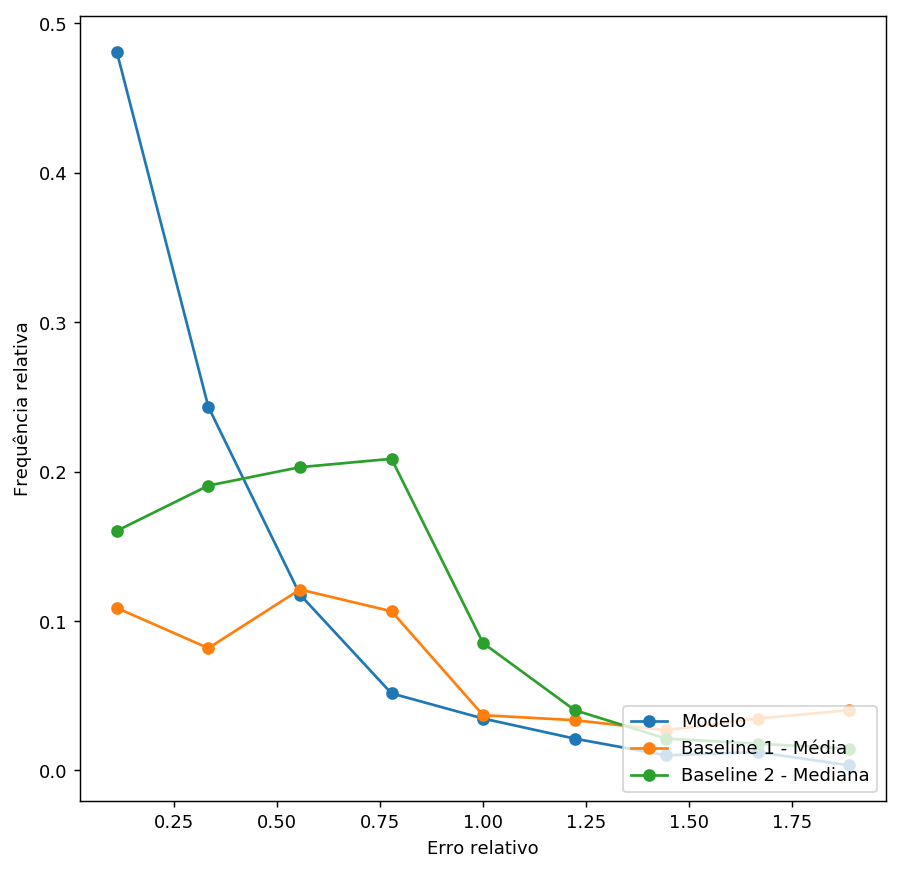

In [25]:
centers, normalized_hist_predicted, normalized_hist_baseline, normalized_hist_baseline_median = shared_functions.plot_relative_error_distribution(predicted_df)

#### Accumulated

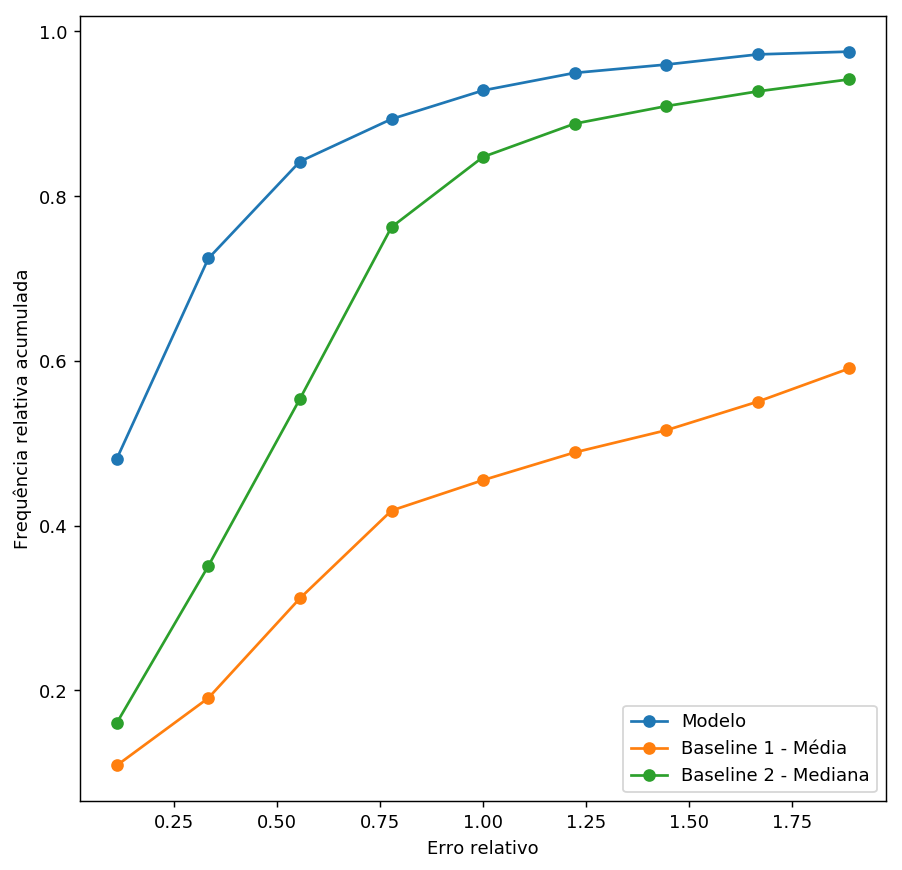

In [26]:
shared_functions.plot_accumulated_relative_error(centers, normalized_hist_predicted, normalized_hist_baseline, normalized_hist_baseline_median)

### Joined data summary

In [27]:
joined_predicted_df.describe(percentiles=[0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99])

,error,error_baseline,error_baseline_median,error_baseline_median_relative,error_baseline_relative,error_relative,prediction,target,id,edition,category8,category9,category10,postProcessed,price,ranking,pages,reviewCount,rating,width,height,depth,weight,eigenvector_centrality,degree,betweenness_centrality
count,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,0.0,0.0,0.0,0.0,892.0,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,892.000000,8.920000e+02,892.000000,892.000000
mean,67.277202,153.124292,123.487758,0.757228,2.165378,0.414582,144.978172,163.823206,1183.433857,NaN,NaN,NaN,NaN,1.0,163.823206,67833.326932,421.384800,16.835074,4.512979,16.412598,23.372910,2.378516,503.756854,1.255699e-02,7.936099,0.006079
std,159.298654,212.634944,250.408456,0.770529,2.375253,0.608827,181.145628,262.082017,1359.596621,NaN,NaN,NaN,NaN,0.0,262.082017,81633.733880,235.836073,43.743689,0.432498,2.690596,2.586905,1.130596,208.487621,2.615698e-02,16.380484,0.016453
min,0.001460,0.023206,0.045000,0.000666,0.000142,0.000040,15.628840,5.900000,3.000000,NaN,NaN,NaN,NaN,1.0,5.900000,7.000000,4.000000,1.000000,1.000000,10.200000,16.800000,0.400000,22.700000,9.095504e-07,1.000000,0.000000
25%,6.276645,76.773206,20.710000,0.337162,0.569565,0.100563,44.819070,40.050000,286.250000,NaN,NaN,NaN,NaN,1.0,40.050000,13336.500000,256.000000,4.000000,4.506240,14.600000,21.775000,1.600000,358.000000,1.556060e-04,1.000000,0.000000
50%,15.728040,115.923206,36.655000,0.607047,1.426113,0.231919,73.108980,67.525000,714.000000,NaN,NaN,NaN,NaN,1.0,67.525000,45810.500000,380.000000,16.212800,4.506240,15.900000,23.000000,2.200000,496.081798,7.383797e-04,3.000000,0.001153
75%,50.571365,134.938206,89.495000,0.880919,3.090470,0.497367,157.987550,157.020000,1851.500000,NaN,NaN,NaN,NaN,1.0,157.020000,69459.166331,544.000000,16.212800,4.700000,17.800000,24.600000,3.000000,621.000000,1.540642e-02,8.000000,0.004048
85%,96.847542,149.092462,215.669000,1.116771,4.135524,0.685678,275.094244,283.194000,2114.700000,NaN,NaN,NaN,NaN,1.0,283.194000,123304.200000,647.350000,16.212800,5.000000,20.400000,27.200000,3.400000,739.000000,3.100157e-02,12.000000,0.007500
90%,168.949984,261.958794,358.257000,1.419473,4.869911,0.913360,376.435780,425.782000,2225.900000,NaN,NaN,NaN,NaN,1.0,425.782000,171689.100000,728.000000,16.212800,5.000000,20.800000,27.600000,3.800000,798.000000,4.195454e-02,18.000000,0.012622
95%,316.869623,456.022794,552.321000,2.076393,6.463673,1.325689,487.637068,619.846000,3389.400000,NaN,NaN,NaN,NaN,1.0,619.846000,268105.450000,863.200000,31.000000,5.000000,21.100000,27.800000,4.400000,898.000000,5.882616e-02,31.450000,0.037404


### Visualize decision tree

In [29]:
shared_functions.render_image_first_decision_tree(rf, feature_list, 'tree-price.png')

Output image:  tree-price.png


<img src="files/image.png">